In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from domino.data.cxr import get_dp, build_cxr_df, get_cxr_activations

In [2]:
# Get a mosaic DataPanel with the data.
df = build_cxr_df.out(load=True)
dp = get_dp(df)
dp.head()

,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),index (ListColumn),input (CellColumn),input2 (CellColumn),img (CellColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'0',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'1',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'2',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'3',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'4',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...


In [3]:
#model_pth = "/media/nvme_data/observational_results_10_2020/original/cxr/emmental_cam/cam_0/seed_0/best_model_target_cxr_val_accuracy.pth"
# ERM with domino path
model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/2021-07-27/19-38-11/wandb/latest-run/files/domino/ecmaw30i/checkpoints/epoch=49-step=17299.ckpt"
# GDRO with scribble labels
# model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/2021-08-01/16-39-48/wandb/latest-run/files/domino/3bolrlyd/checkpoints/epoch=49-step=17299.ckpt"
# subsampling with scribble labels
#model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/2021-08-01/17-34-23/wandb/latest-run/files/domino/2pygz03t/checkpoints/epoch=49-step=17299.ckpt"

# GDRO with gaze train set
#model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/2021-08-02/18-49-29/wandb/latest-run/files/domino/2o2sam80/checkpoints/epoch=49-step=1499.ckpt" 
# undersample train to remove correlation (on gaze train set)
# model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/2021-08-06/18-11-35/wandb/latest-run/files/domino/vhcmqiax/checkpoints/epoch=49-step=499.ckpt"
# multiclass (on gaze train set)
#model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/2021-08-07/20-52-03/wandb/latest-run/files/domino/1g0l0dzn/checkpoints/epoch=49-step=1499.ckpt"


act_dp = get_cxr_activations(dp=dp, model_path=model_pth, run_type="domino")
act_dp.head()

100%|██████████| 753/753 [02:55<00:00,  4.29it/s]


,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),index (ListColumn),input (CellColumn),input2 (CellColumn),img (CellColumn),output (ClassificationOutputColumn),activation_block3 (TensorColumn),activation_block4 (TensorColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'0',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'1',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'2',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'3',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'4',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"


In [6]:
train_mask = dp["gaze_seq"].data != "nan"
test_mask = np.logical_and(~train_mask, ~np.isnan(dp["chest_tube"]))

# overall performance
test_probs = act_dp[test_mask]["output"].data[:,1]
test_labels = act_dp[test_mask]["pmx"].data
print(f"Overall AUROC: {roc_auc_score(test_labels,test_probs):.3f}")

# AUROC performance on subset that has tube labels
tubes_mask = np.array(act_dp[test_mask]["chest_tube"] == 1)
print(f"With tubes AUROC: {roc_auc_score(test_labels[tubes_mask],test_probs[tubes_mask]):.3f}")

# AUROC performance on subset that has no tube labels
notubes_mask = np.array(act_dp[test_mask]["chest_tube"] == 0)
print(f"Without tubes AUROC: {roc_auc_score(test_labels[notubes_mask],test_probs[notubes_mask]):.3f}")

neg_mask = np.array(act_dp[test_mask]["pmx"] == 0)
pos_mask = np.array(act_dp[test_mask]["pmx"] == 1)
tube_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,tubes_mask))
notube_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,notubes_mask))

print(f"All positives have tubes, AUROC: {roc_auc_score(test_labels[tube_in_pos_mask],test_probs[tube_in_pos_mask]):.3f}")
print(f"All positives have no tubes, AUROC: {roc_auc_score(test_labels[notube_in_pos_mask],test_probs[notube_in_pos_mask]):.3f}")

tube_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,tubes_mask))
notube_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,notubes_mask))

print(f"All negatives have tubes, AUROC: {roc_auc_score(test_labels[tube_in_neg_mask],test_probs[tube_in_neg_mask]):.3f}")
print(f"All negatives have no tubes, AUROC: {roc_auc_score(test_labels[notube_in_neg_mask],test_probs[notube_in_neg_mask]):.3f}")

Overall AUROC: 0.888
With tubes AUROC: 0.763
Without tubes AUROC: 0.832
All positives have tubes, AUROC: 0.920
All positives have no tubes, AUROC: 0.799
All negatives have tubes, AUROC: 0.704
All negatives have no tubes, AUROC: 0.911


In [7]:
mask = np.logical_or(np.logical_and(pos_mask,notubes_mask), np.logical_and(neg_mask,tubes_mask))
print(f"All negatives have tubes, All positives have no tube, AUROC: {roc_auc_score(test_labels[mask],test_probs[mask]):.3f}")


All negatives have tubes, All positives have no tube, AUROC: 0.542


In [17]:
roc_auc_score(act_dp[test_mask]["chest_tube"],test_probs)

0.8682547225245387

## Analyze incorrect predictions in different slices

In [5]:
def vis_preds(dp):
    
    for row in dp:
       _, axes = plt.subplots(1, 1, figsize=(8,8))
       axes.axis("OFF")
       inp = np.array(row["img"].resize((512,512)))
       axes.imshow(inp, cmap="gray")
       axes.set_title(f"{row['output'][1].sigmoid():.3f}",fontsize=30)


In [19]:
class_type = "negative"

if class_type == "positive":
    class_mask = act_dp["pmx"] == 1
    tube_mask = act_dp["chest_tube"] == 0
    mask = np.logical_and(test_mask,np.logical_and(class_mask,tube_mask))
    act_dp_sorted = act_dp[mask][np.argsort(act_dp["output"].data[:,1].numpy()[mask])]
else:
    class_mask = act_dp["pmx"] == 0
    tube_mask = act_dp["chest_tube"] == 1
    mask = np.logical_and(test_mask,np.logical_and(class_mask,tube_mask))
    act_dp_sorted = act_dp[mask][np.argsort(-1*act_dp["output"].data[:,1].numpy()[mask])]

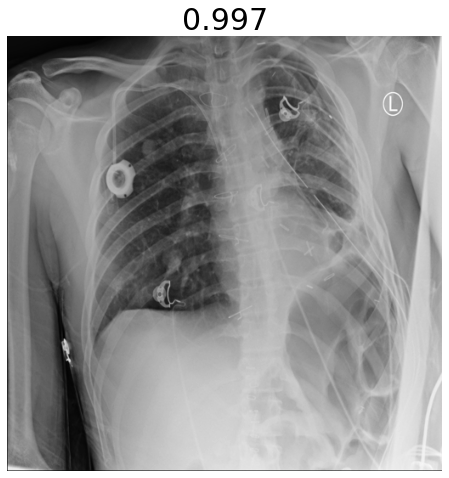

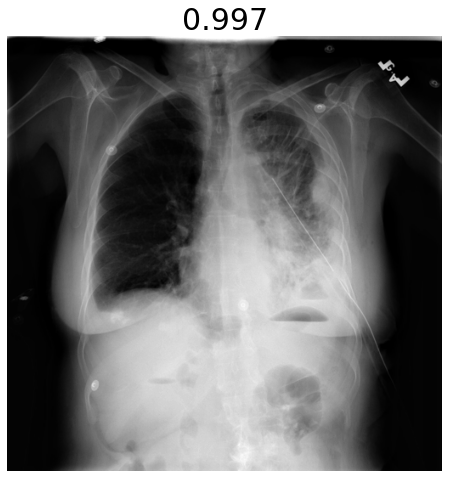

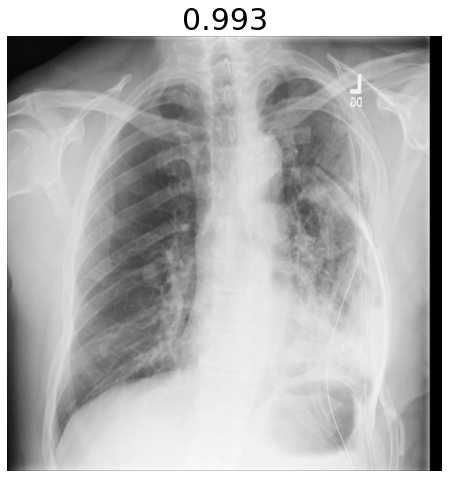

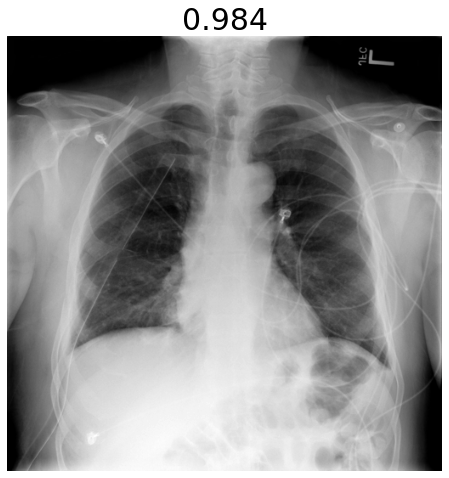

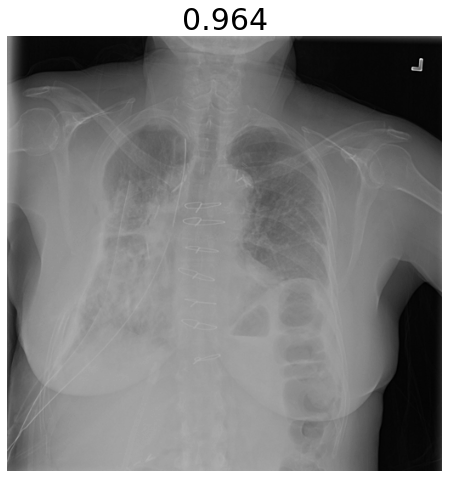

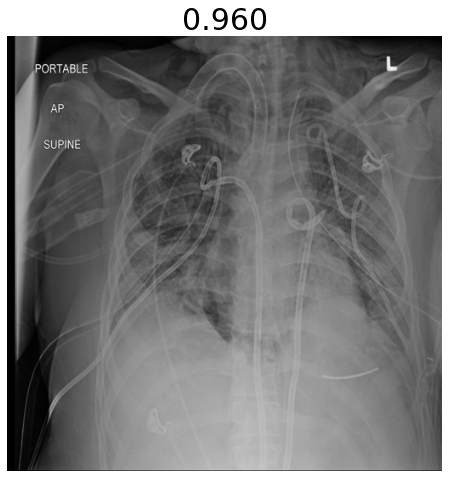

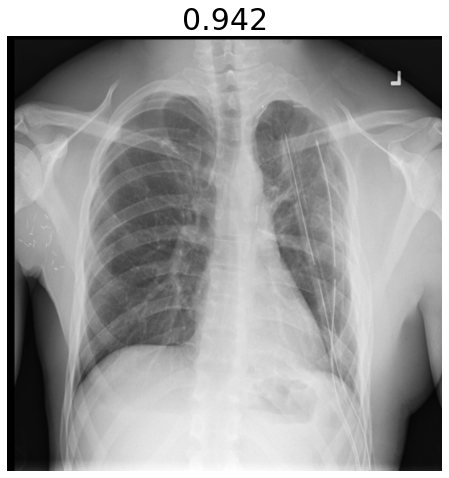

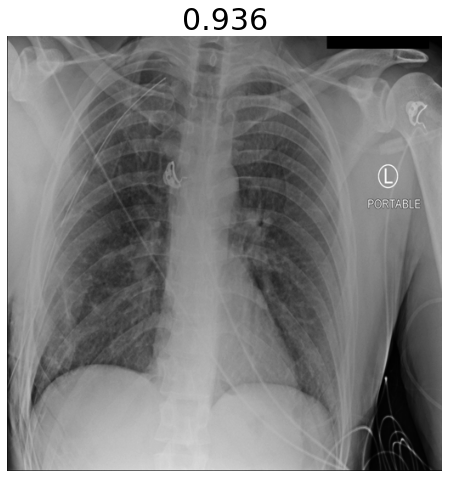

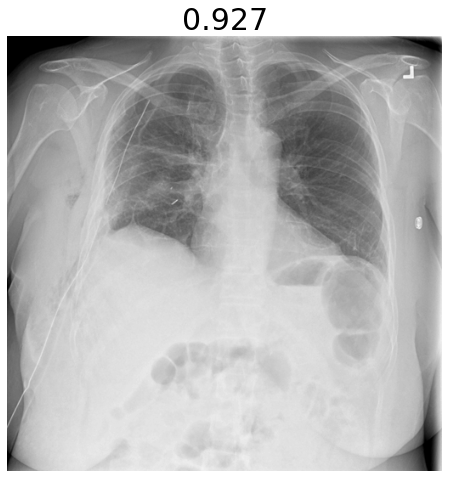

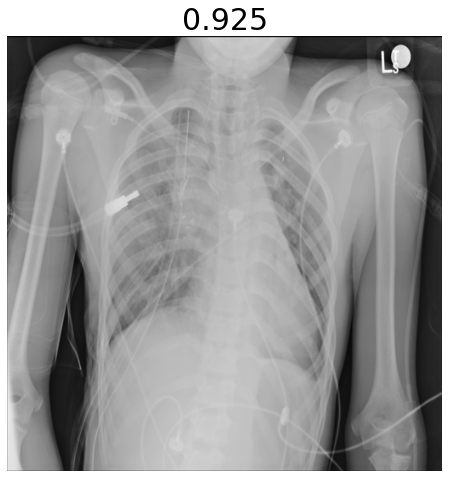

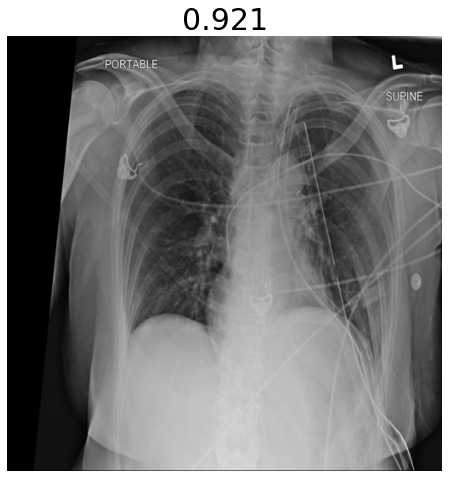

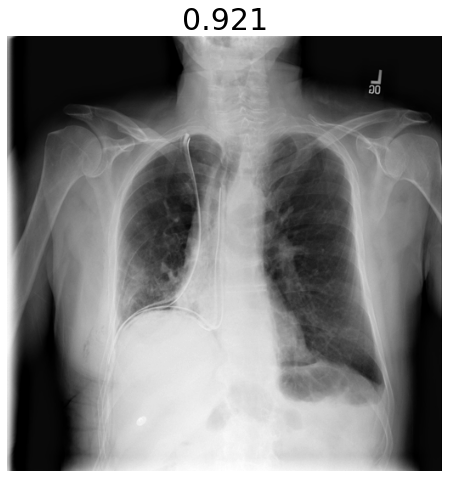

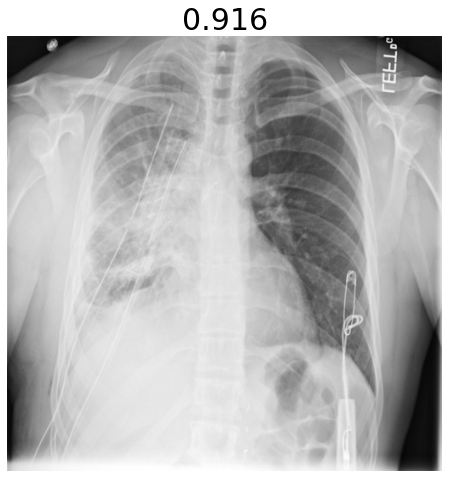

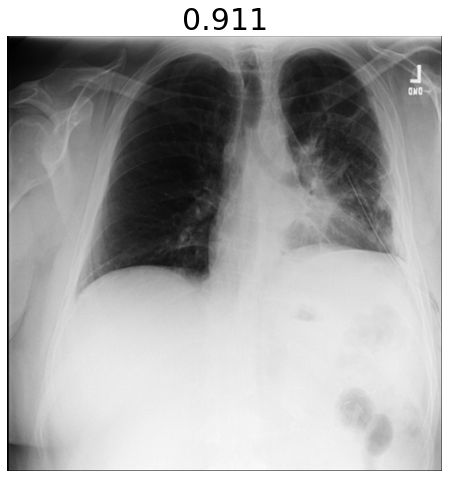

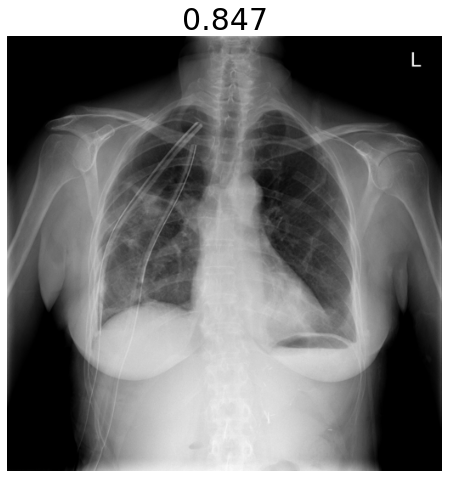

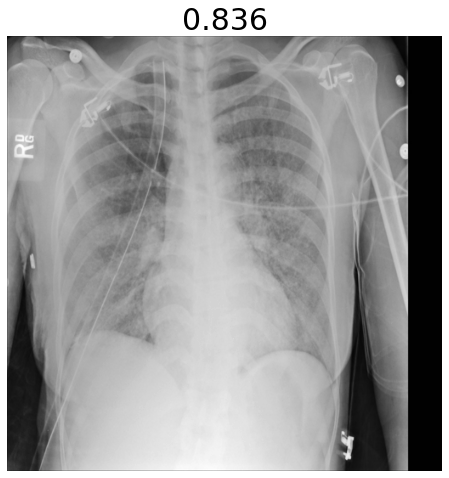

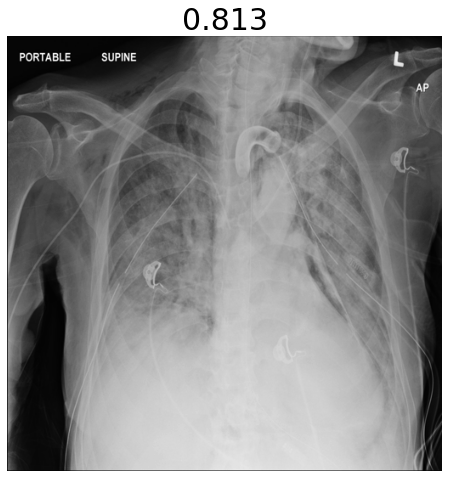

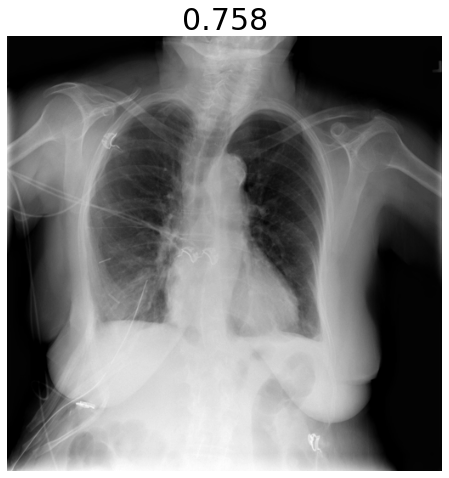

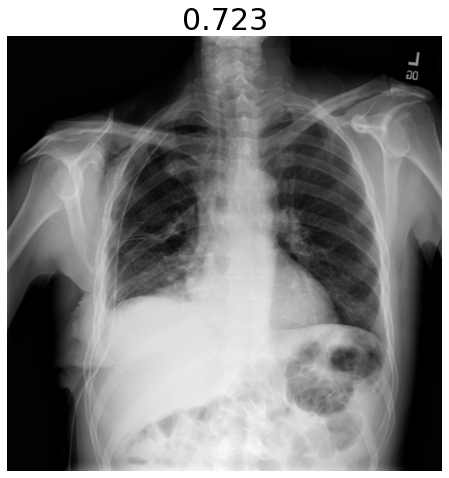

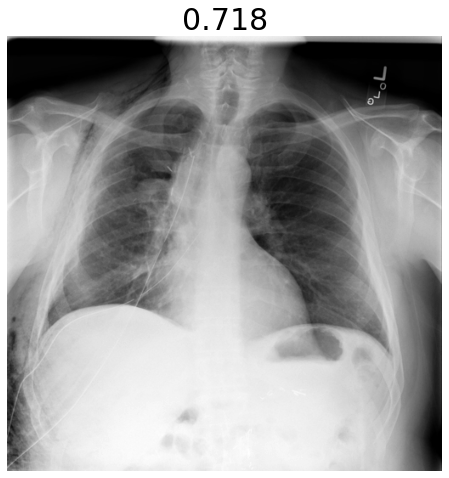

In [20]:
vis_preds(act_dp_sorted[:20])